# Comparison of three dimension reduction techniques: PCA, GPLVM, and GPDM
From [Gregory Gundersen's Blog: GPDM paper](https://gregorygundersen.com/blog/2020/07/24/gpdm/)

##  1.Generating the data:

In [7]:
import numpy as np
from  sklearn.datasets import make_s_curve

# 
def gen_data():
    T    = 200
    J    = 40
    X, t = make_s_curve(T)
    X    = np.delete(X, obj=1, axis=1)
    X    = X / np.std(X, axis=0)
    D    = X.shape[1]
    inds = t.argsort()
    X    = X[inds]
    t    = t[inds]
    K    = rbf_kernel(X, 1, 1, 0)
    F    = np.random.multivariate_normal(np.zeros(T), K, size=J).T
    Y    = F + np.random.normal(0, scale=1, size=F.shape)
    return X, Y, t


def rbf_kernel(X, var, length_scale, diag):
    T = len(X)
    diffs = np.expand_dims(X / length_scale, 1) \
          - np.expand_dims(X / length_scale, 0)
    return var * np.exp(-0.5 * np.sum(diffs ** 2, axis=2)) + diag * np.eye(T)

## 2.Fitting a GPDM

In [8]:
import autograd.numpy as np
from   autograd import grad
from   scipy.optimize import fmin_l_bfgs_b
from   sklearn.decomposition import PCA


def log_posterior(Y, X, beta, alpha):
    _, J = Y.shape

    K_Y      = rbf_kernel(X, *beta)
    det_term = -J/2 * np.prod(np.linalg.slogdet(K_Y))
    tr_term  = -1/2 * np.trace(np.linalg.inv(K_Y) @ Y @ Y.T)
    LL       = det_term + tr_term

    K_X      = rbf_linear_kernel(X[:-1], *alpha)
    X_bar    = X[1:]
    det_term = -D/2 * np.prod(np.linalg.slogdet(K_X))
    tr_term  = -1/2 * np.trace(np.linalg.inv(K_X) @ X_bar @ X_bar.T)
    LP       = det_term + tr_term

    return LL + LP


def rbf_linear_kernel(X, var, length_scale, diag1, diag2):
    rbf = rbf_kernel(X, length_scale, var, diag1)
    linear = diag2 * X @ X.T
    return rbf + linear


def optimize_gpdm(Y, X0):
    T, D = X0.shape

    beta0 = np.array([1, 1, 1e-6])
    alpha0 = np.array([1, 1, 1e-6, 1e-6])

    def _neg_f(params):
        X = params[:T*D].reshape(X0.shape)
        beta = params[T*D:T*D+3]
        alpha = params[T*D+3:]
        return -1 * log_posterior(Y, X, beta, alpha)

    _neg_fp = grad(_neg_f)
    
    def f_fp(params):
        return _neg_f(params), _neg_fp(params)

    x0 = np.concatenate([X0.flatten(), beta0, alpha0])
    res = fmin_l_bfgs_b(f_fp, x0)
    X_map = res[0][:T*D].reshape(X0.shape)

    return X_map

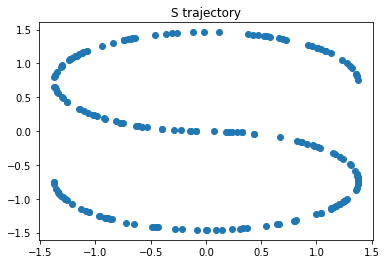

In [27]:
import matplotlib.pyplot as plt
X, Y, t = gen_data()

plt.scatter(X[:,0], X[:,1])
plt.title('S trajectory')
plt.show()


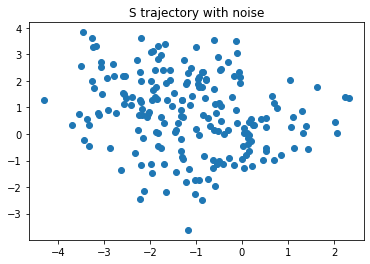

In [26]:
plt.scatter(Y[:,0], Y[:,1])
plt.title('S trajectory with noise')
plt.show()